# Data Engineering

## Full

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

import lightgbm as lgb
from lightgbm import LGBMClassifier

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [171]:
df = pd.read_csv("data/data_cleaned_raw.csv")
df["genre"] = df["genre"].astype("category").cat.codes
df['time'] = pd.to_numeric(df['time'])

Aggregating the columns and creating new features:

In [114]:
# Extract 'genre' information before aggregation
# genre_df = df[['label', 'genre']].drop_duplicates()
# genre_mapping = {'POP': 1, 'HIPHOP': 2, 'SLOW': 3, 'TECHNO': 4}
# genre_df['genre'] = genre_df['genre'].map(genre_mapping)

In [2431]:
# Columns to aggregate
columns_to_aggregate = ['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z', 'mag_x', 'mag_y', 'mag_z']

# Aggregation functions
agg_funcs = ['max', 'min', 'std', 'mean', 'median']

# Create a dictionary with columns and aggregation functions
agg_dict = {col: agg_funcs for col in columns_to_aggregate}
# Add the genre aggregation, assuming it is constant per group
agg_dict['genre'] = 'first'

# Grouping and aggregation
grouped_df = df.groupby(['subject_id', 'label']).agg(agg_dict).reset_index()

# Flatten MultiIndex columns
grouped_df.columns = ['_'.join(filter(None, col)).strip() for col in grouped_df.columns]

KeyError: "Column(s) ['acc_x', 'acc_y', 'acc_z', 'genre', 'gy_x', 'gy_y', 'gy_z', 'mag_x', 'mag_y', 'mag_z'] do not exist"

In [117]:
# Merge 'genre' back into the aggregated DataFrame
# df = grouped_df.merge(genre_df, on=['label'], how='left')

## Aggregation

In [3]:
df = pd.read_csv("data/data_cleaned_raw.csv")
df["genre"] = df["genre"].astype("category").cat.codes
df['time'] = pd.to_numeric(df['time'])

In [2089]:
def map_name_to_good_dancer(name):
    if name in ["arda", "sietske", "luna"]:
        return 1
    else:
        return 0

# Assuming df is your DataFrame
df['good_dancer'] = df['subject_name'].apply(lambda x: map_subject_name(x))

In [2090]:
def map_name_to_gender(name):
    if name in ["arda", "uzun_boylu_cinli_eleman", "uzun_siyah_sacli_eleman"]:
        return 1
    else:
        return 0

# Assuming df is your DataFrame
df['gender'] = df['subject_name'].apply(lambda x: map_name_to_gender(x))

In [12]:
from src.engineering import *
result_df = aggregate_data(df)
df = result_df.copy()

# Modelling

## Train-Test Split

In [81]:
from src.split_data import *
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, train_size=4, val_size=1)

## Classification

In [82]:
# Initialize the LGBMClassifier
model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=50,
    learning_rate=0.05,
    n_estimators=100)

# Fit the model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Make predictions on the test set
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 54
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [83]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.88


In [84]:
# lgb.plot_importance(model, importance_type="gain", figsize=(10, 80), title="LightGBM Feature Importance (Gain)")

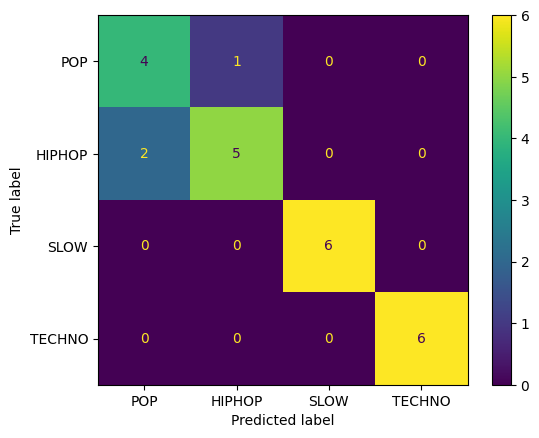

In [85]:
conf_mat = confusion_matrix(y_pred, y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=['POP','HIPHOP','SLOW','TECHNO'])
disp.plot()
plt.show()